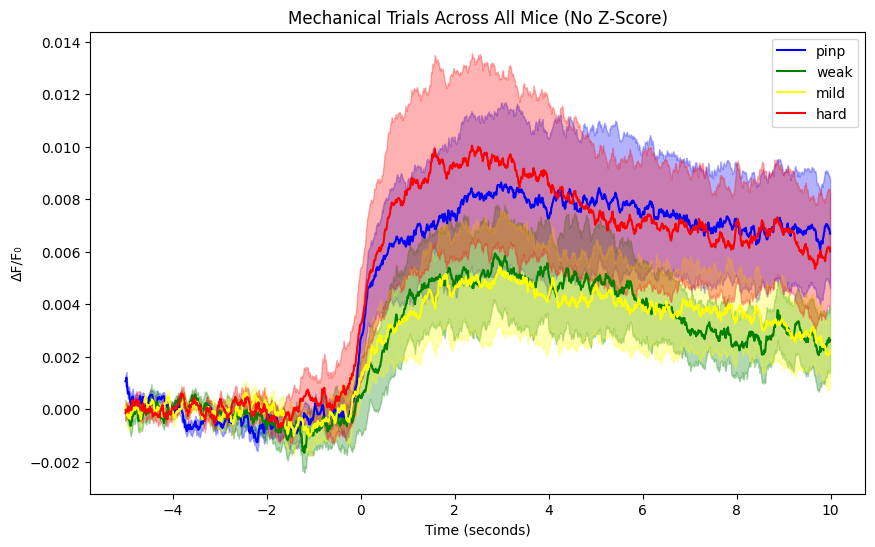

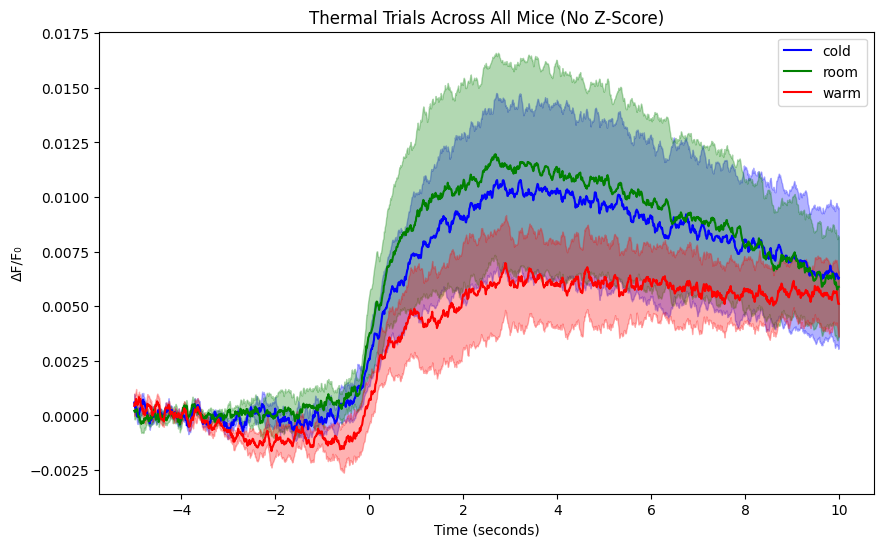

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

sampling_rate=100

# Path to the uploaded zip file
extract_folder_path =r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\\'  # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to extract trials for each animal
def extract_trials_per_animal(animal_data, trial_types):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                animal_trials[trial] = data.item()[trial]
        trials[animal] = animal_trials
    return trials

# Extracting trials for each animal
mechanical_data_no_zscore = extract_trials_per_animal(all_data, mechanical_trials)
thermal_data_no_zscore = extract_trials_per_animal(all_data, thermal_trials)

# Function to calculate average and SEM across all animals for each trial type
def calculate_avg_sem_across_animals(data_per_animal, trial_types):
    avg_sem = {}
    for trial in trial_types:
        trial_data = np.array([animal_data[trial] for animal_data in data_per_animal.values() if trial in animal_data])
        avg, sem_val = np.mean(trial_data, axis=0), sem(trial_data, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Calculating average and SEM for mechanical and thermal trials
mechanical_avg_sem_no_zscore = calculate_avg_sem_across_animals(mechanical_data_no_zscore, mechanical_trials)
thermal_avg_sem_no_zscore = calculate_avg_sem_across_animals(thermal_data_no_zscore, thermal_trials)

# Defining custom color codes for each trial type
color_codes = {
    'average_trace_cold': 'blue',
    'average_trace_room': 'green',
    'average_trace_warm': 'red',
    'average_trace_pinp': 'blue',
    'average_trace_weak': 'green',
    'average_trace_mild': 'yellow',
    'average_trace_hard': 'red'
}

# Modified plotting function with custom color codes
def plot_trials_with_colors(trial_data, title, sampling_rate, color_codes):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(-5, 10, 1/sampling_rate)
    for trial, (avg, error) in trial_data.items():
        color = color_codes.get(trial, 'black')  # Default color is black if not specified
        plt.plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        plt.fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('ΔF/F₀')
    plt.legend()
    
    # saving the figure
    
    save_path = os.path.join(os.path.dirname(extract_folder_path), title + '.pdf')
    plt.savefig(save_path, format='pdf', dpi=300)
    plt.show()
    

# Plotting the trials


plot_trials_with_colors(mechanical_avg_sem_no_zscore, "Mechanical Trials Across All Mice (No Z-Score)", sampling_rate, color_codes)
plot_trials_with_colors(thermal_avg_sem_no_zscore, "Thermal Trials Across All Mice (No Z-Score)", sampling_rate, color_codes)

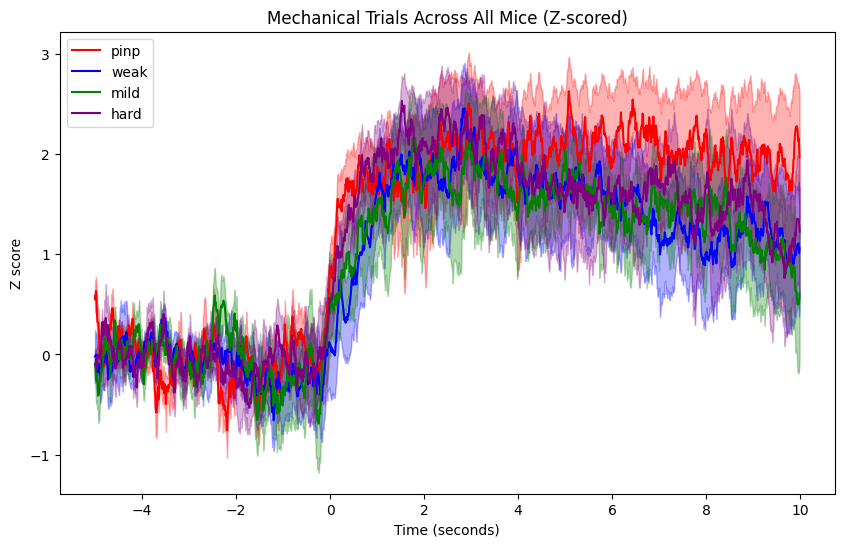

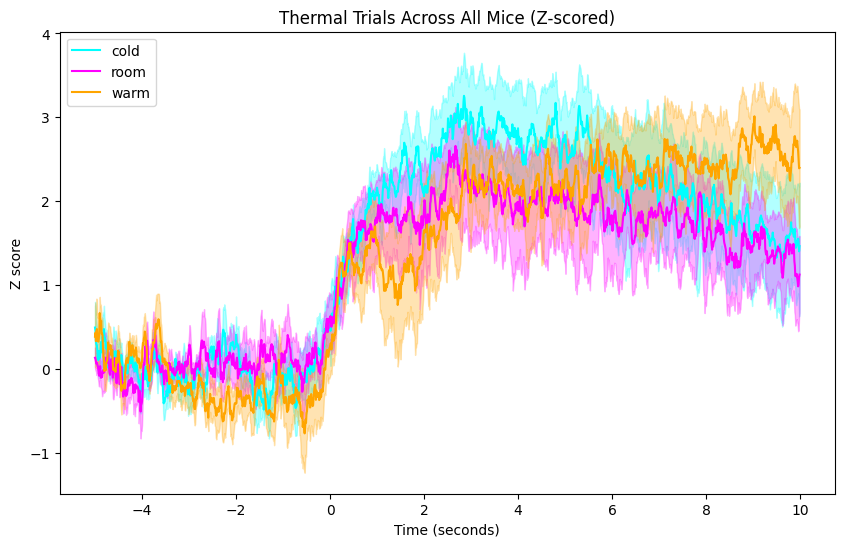

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the uploaded zip file
extract_folder_path = r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\\'   # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to apply z-score normalization and zero out a specific period
def zscore_and_zero_period(data, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    # Applying z-score normalization with baseline
    baseline_indices = (np.arange(baseline_start, baseline_end, 1/sampling_rate) * sampling_rate).astype(int)
    baseline_mean = np.mean(data[baseline_indices])
    baseline_std = np.std(data[baseline_indices])
    normalized_data = (data - baseline_mean) / baseline_std

    # Zeroing out the specific period
    zero_indices = (np.arange(zero_start, zero_end, 1/sampling_rate) * sampling_rate).astype(int)
    zero_mean = np.mean(normalized_data[zero_indices])
    return normalized_data - zero_mean

# Function to extract, normalize, and zero out trials for each animal
def extract_normalize_zero_trials_per_animal(animal_data, trial_types, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                processed_data = zscore_and_zero_period(data.item()[trial], baseline_start, baseline_end, zero_start, zero_end, sampling_rate)
                animal_trials[trial] = processed_data
        trials[animal] = animal_trials
    return trials

# Extracting, normalizing, and zeroing out trials for each animal
baseline_start_sec = 0  # Starting point of the baseline in seconds
baseline_end_sec = 5   # Ending point of the baseline in seconds
zero_start_sec = 0     # Starting point of zeroing out period in seconds
zero_end_sec = 2       # Ending point of zeroing out period in seconds

mechanical_data_processed = extract_normalize_zero_trials_per_animal(all_data, mechanical_trials, 
                                                                     baseline_start_sec, baseline_end_sec, 
                                                                     zero_start_sec, zero_end_sec, 130)
thermal_data_processed = extract_normalize_zero_trials_per_animal(all_data, thermal_trials, 
                                                                  baseline_start_sec, baseline_end_sec, 
                                                                  zero_start_sec, zero_end_sec, 130)

# Calculating average and SEM for mechanical and thermal trials with processed data
mechanical_avg_sem_processed = calculate_avg_sem_across_animals(mechanical_data_processed, mechanical_trials)
thermal_avg_sem_processed = calculate_avg_sem_across_animals(thermal_data_processed, thermal_trials)

# Modified plotting function with custom color codes
def plot_trials_with_colors_zscore(trial_data, title, sampling_rate, color_codes):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(-5, 10, 1/sampling_rate)
    for trial, (avg, error) in trial_data.items():
        color = color_codes.get(trial, 'black')  # Default color is black if not specified
        plt.plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        plt.fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Z score')
    plt.legend()
    # saving the figure
    
    save_path = os.path.join(os.path.dirname(extract_folder_path), title + '.1.pdf')
    plt.savefig(save_path, format='pdf', dpi=300)
    plt.show()
    plt.show()

# Plotting the trials with processed data
plot_trials_with_colors_zscore(mechanical_avg_sem_processed, "Mechanical Trials Across All Mice (Z-scored)", sampling_rate, color_codes)
plot_trials_with_colors_zscore(thermal_avg_sem_processed, "Thermal Trials Across All Mice (Z-scored)", sampling_rate, color_codes)

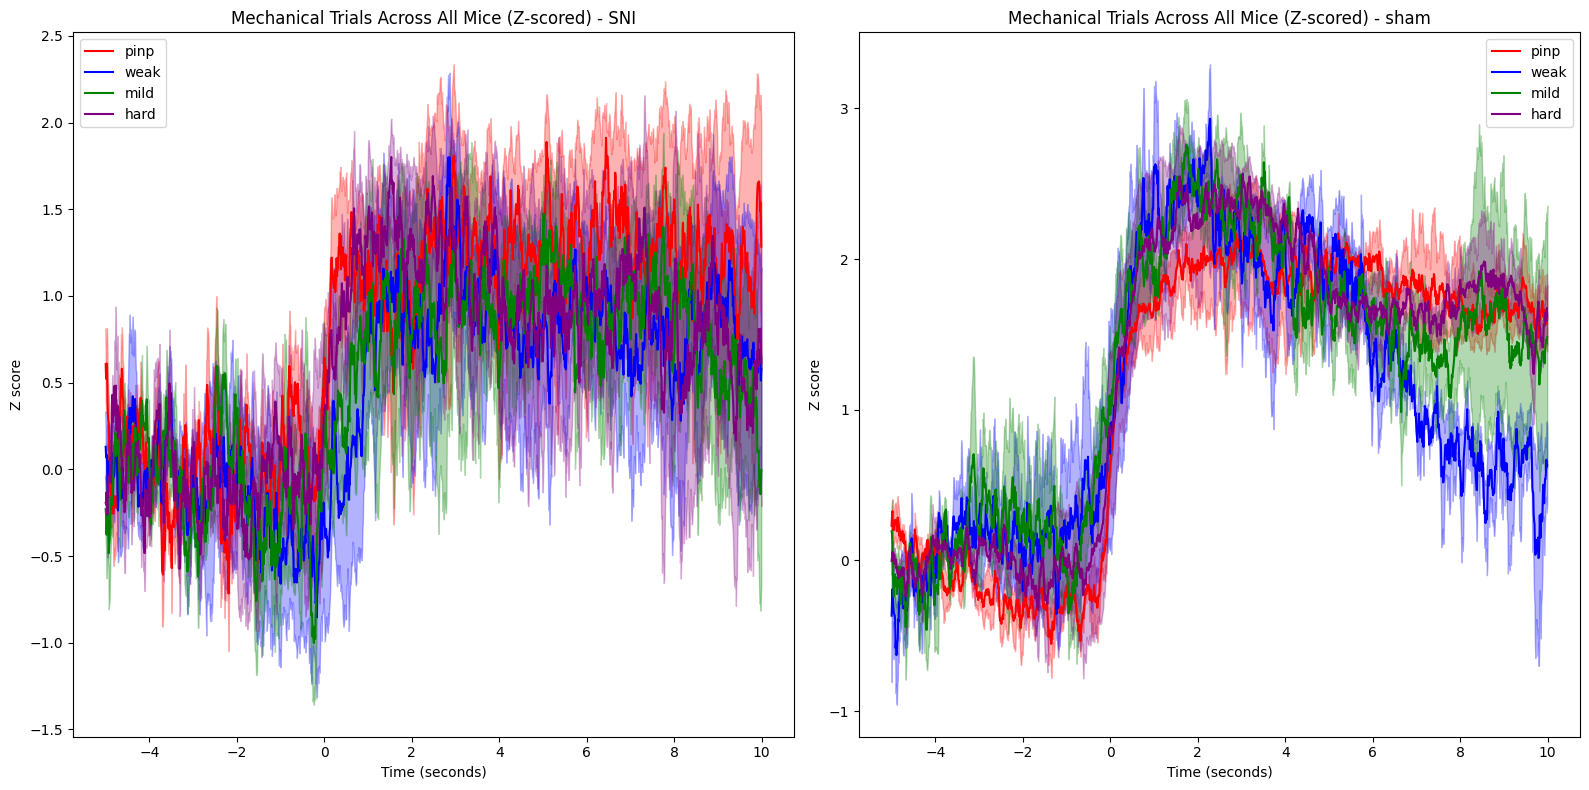

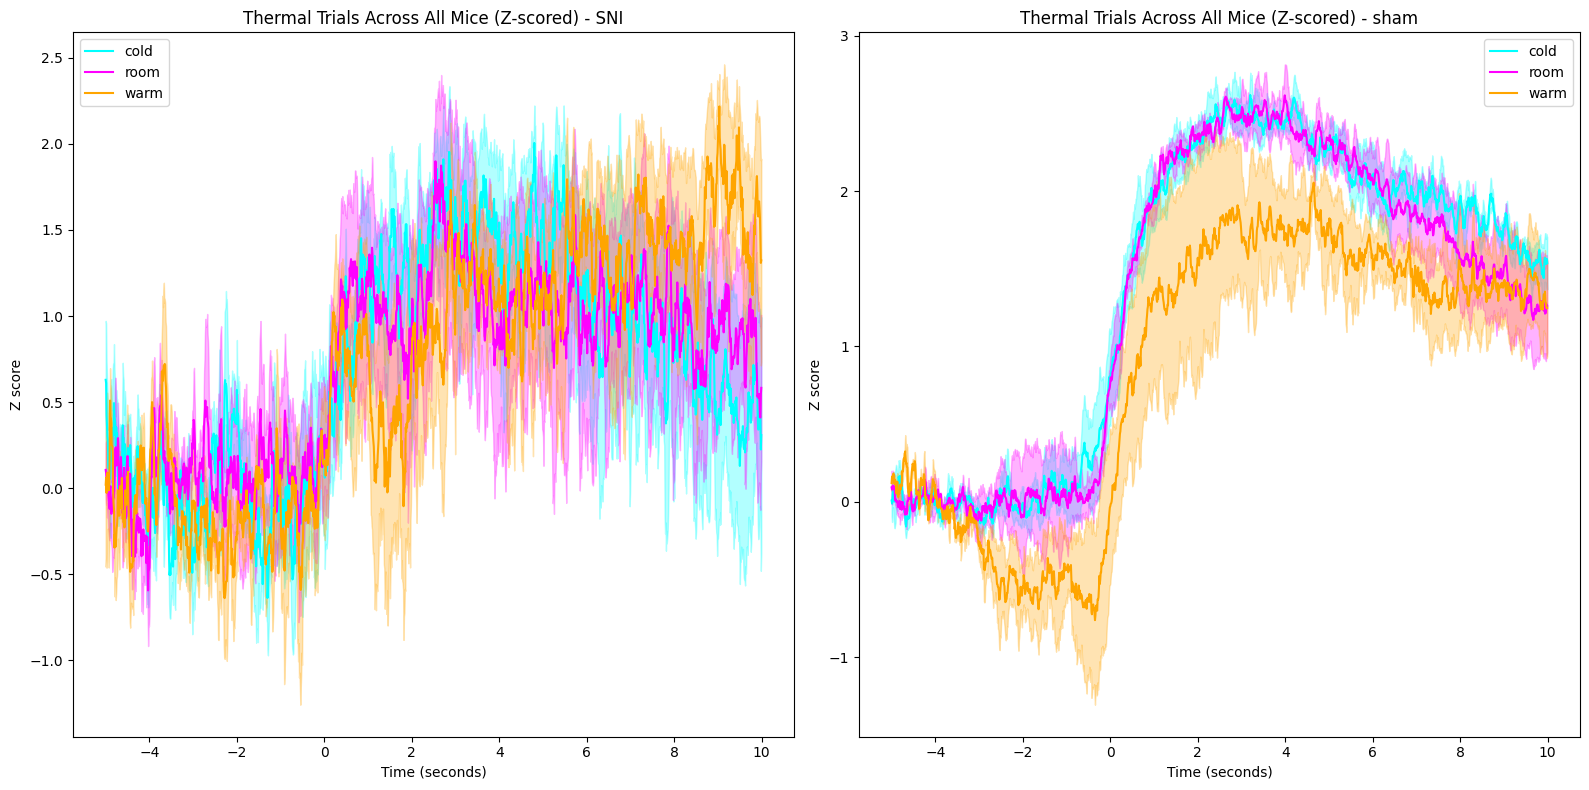

'\nplot_trials_with_colors_zscore_subplot(mechanical_avg_sem_sni, mechanical_avg_sem_sni, \n                                       "Mechanical Trials Across All Mice (Z-scored)", sampling_rate, color_codes)\nplot_trials_with_colors_zscore_subplot(thermal_avg_sem_sham, thermal_avg_sem_sham, \n                                       "Thermal Trials Across All Mice (Z-scored)", sampling_rate, color_codes)\n'

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Function to calculate average and SEM across all animals for each trial type
def calculate_avg_sem_across_animals(data_per_animal, trial_types):
    avg_sem = {}
    for trial in trial_types:
        trial_data = np.array([animal_data[trial] for animal_data in data_per_animal.values() if trial in animal_data])
        avg, sem_val = np.mean(trial_data, axis=0), sem(trial_data, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Path to the uploaded zip files for sni and sni-ctrl conditions
extract_folder_path_sni = r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\SNI\\'
extract_folder_path_sham = r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\sham\\'


# Loading the data from .npy files for both conditions
all_data_sni = {animal: np.load(os.path.join(extract_folder_path_sni, animal), allow_pickle=True) 
                for animal in os.listdir(extract_folder_path_sni) if animal.endswith('.npy')}
all_data_sham = {animal: np.load(os.path.join(extract_folder_path_sham, animal), allow_pickle=True) 
                     for animal in os.listdir(extract_folder_path_sham) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to apply z-score normalization and zero out a specific period
def zscore_and_zero_period(data, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    # Applying z-score normalization with baseline
    baseline_indices = (np.arange(baseline_start, baseline_end, 1/sampling_rate) * sampling_rate).astype(int)
    baseline_mean = np.mean(data[baseline_indices])
    baseline_std = np.std(data[baseline_indices])
    normalized_data = (data - baseline_mean) / baseline_std

    # Zeroing out the specific period
    zero_indices = (np.arange(zero_start, zero_end, 1/sampling_rate) * sampling_rate).astype(int)
    zero_mean = np.mean(normalized_data[zero_indices])
    return normalized_data - zero_mean

# Function to extract, normalize, and zero out trials for each animal
def extract_normalize_zero_trials_per_animal(animal_data, trial_types, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                processed_data = zscore_and_zero_period(data.item()[trial], baseline_start, baseline_end, zero_start, zero_end, sampling_rate)
                animal_trials[trial] = processed_data
        trials[animal] = animal_trials
    return trials

# Extracting, normalizing, and zeroing out trials separately for each condition
baseline_start_sec = 0  # Starting point of the baseline in seconds
baseline_end_sec = 15   # Ending point of the baseline in seconds
zero_start_sec = 0     # Starting point of zeroing out period in seconds
zero_end_sec = 2       # Ending point of zeroing out period in seconds

# Process sni and sni-ctrl data separately for z-scoring
sni_data_processed = extract_normalize_zero_trials_per_animal(all_data_sni, 
                                                              mechanical_trials + thermal_trials, 
                                                              baseline_start_sec, baseline_end_sec, 
                                                              zero_start_sec, zero_end_sec, sampling_rate)

sham_data_processed = extract_normalize_zero_trials_per_animal(all_data_sham, 
                                                                   mechanical_trials + thermal_trials, 
                                                                   baseline_start_sec, baseline_end_sec, 
                                                                   zero_start_sec, zero_end_sec, sampling_rate)

# Calculating average and SEM for mechanical and thermal trials with processed data for both conditions
mechanical_avg_sem_sni = calculate_avg_sem_across_animals(sni_data_processed, mechanical_trials)
thermal_avg_sem_sni = calculate_avg_sem_across_animals(sni_data_processed, thermal_trials)
mechanical_avg_sem_sham = calculate_avg_sem_across_animals(sham_data_processed, mechanical_trials)
thermal_avg_sem_sham = calculate_avg_sem_across_animals(sham_data_processed, thermal_trials)

# Modified plotting function to display subplots for SNI and SNI-CTRL
def plot_trials_with_colors_zscore_subplot(trial_data_sni, trial_data_sham, title, sampling_rate, color_codes):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    time_axis = np.arange(-5, 10, 1/sampling_rate)

    for trial, (avg, error) in trial_data_sni.items():
        color = color_codes.get(trial, 'black')
        axes[0].plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        axes[0].fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    axes[0].set_title(f"{title} - SNI")
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Z score')
    axes[0].legend()
    

    for trial, (avg, error) in trial_data_sham.items():
        color = color_codes.get(trial, 'black')
        axes[1].plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        axes[1].fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    axes[1].set_title(f"{title} - sham")
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Z score')
    axes[1].legend()

    plt.tight_layout()
    # saving the figure
    
    save_path = os.path.join(os.path.dirname(extract_folder_path), title + '.2.pdf')
    plt.savefig(save_path, format='pdf', dpi=300)
    
    plt.show()

# Define custom color codes
color_codes = {
    'average_trace_pinp': 'red',
    'average_trace_weak': 'blue',
    'average_trace_mild': 'green',
    'average_trace_hard': 'purple',
    'average_trace_cold': 'cyan',
    'average_trace_room': 'magenta',
    'average_trace_warm': 'orange'
}

# Plotting the trials with processed data in subplots
plot_trials_with_colors_zscore_subplot(mechanical_avg_sem_sni, mechanical_avg_sem_sham, 
                                       "Mechanical Trials Across All Mice (Z-scored)", sampling_rate, color_codes)
plot_trials_with_colors_zscore_subplot(thermal_avg_sem_sni, thermal_avg_sem_sham, 
                                       "Thermal Trials Across All Mice (Z-scored)", sampling_rate, color_codes)



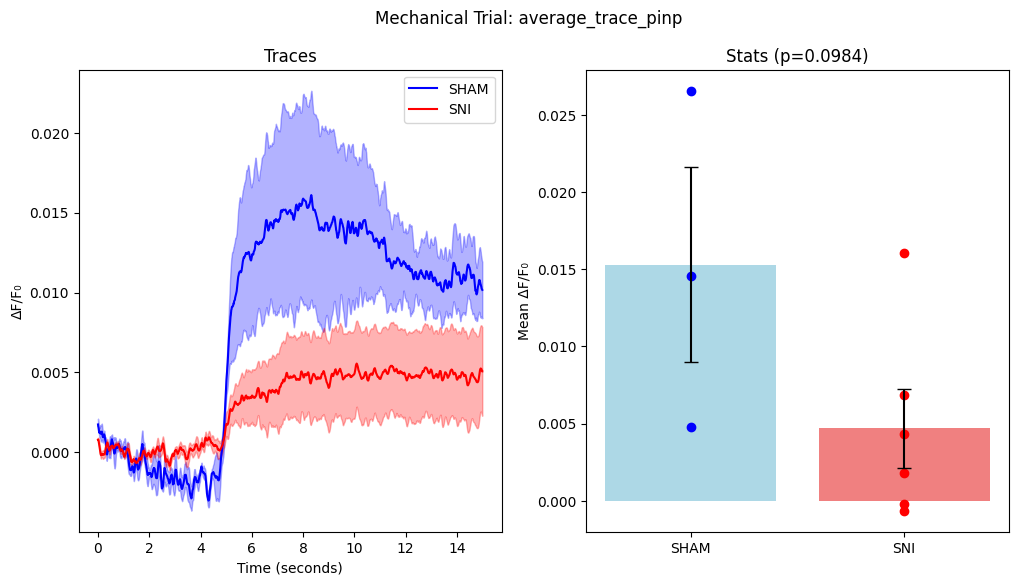

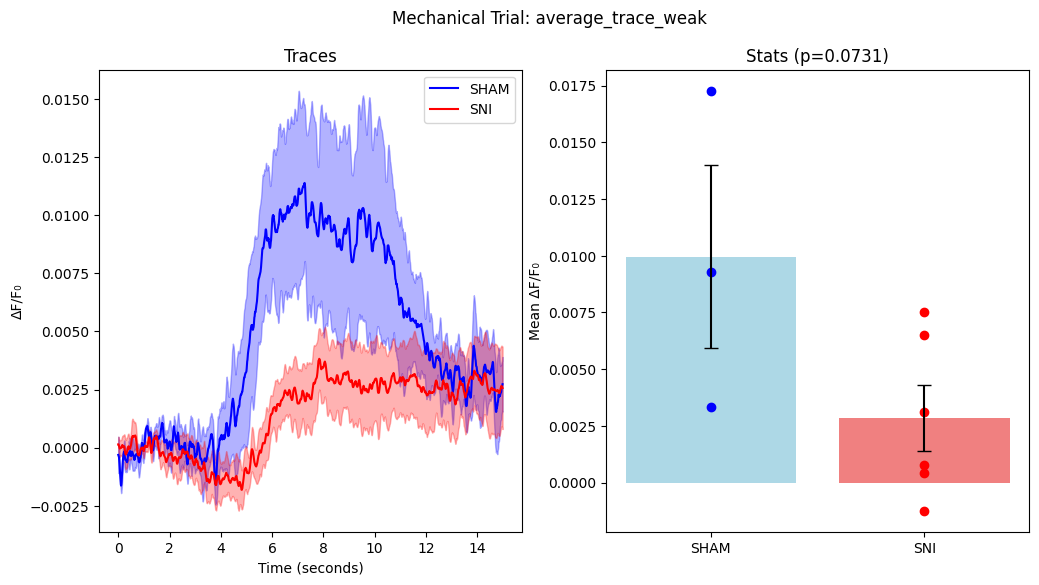

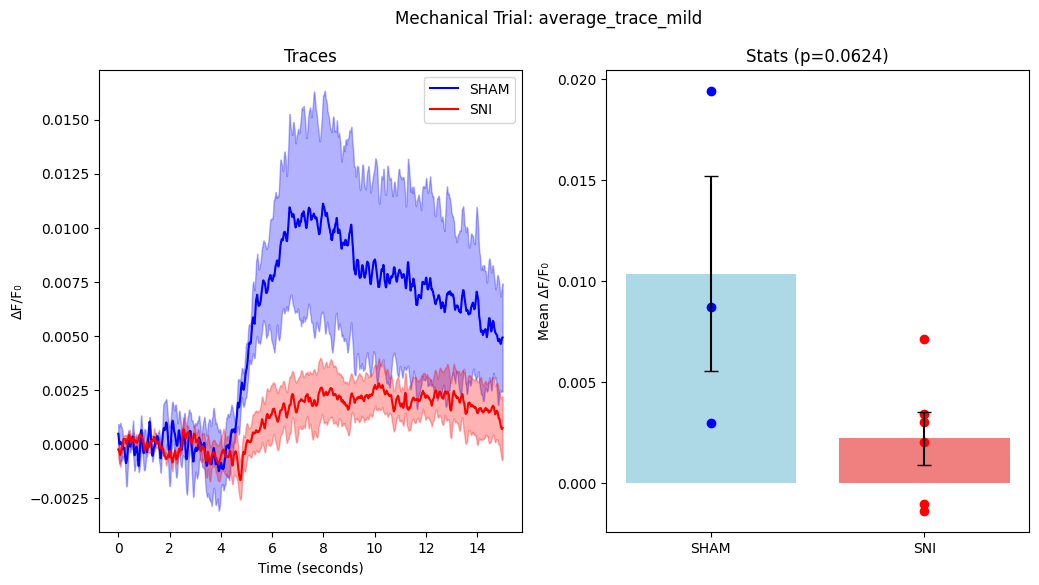

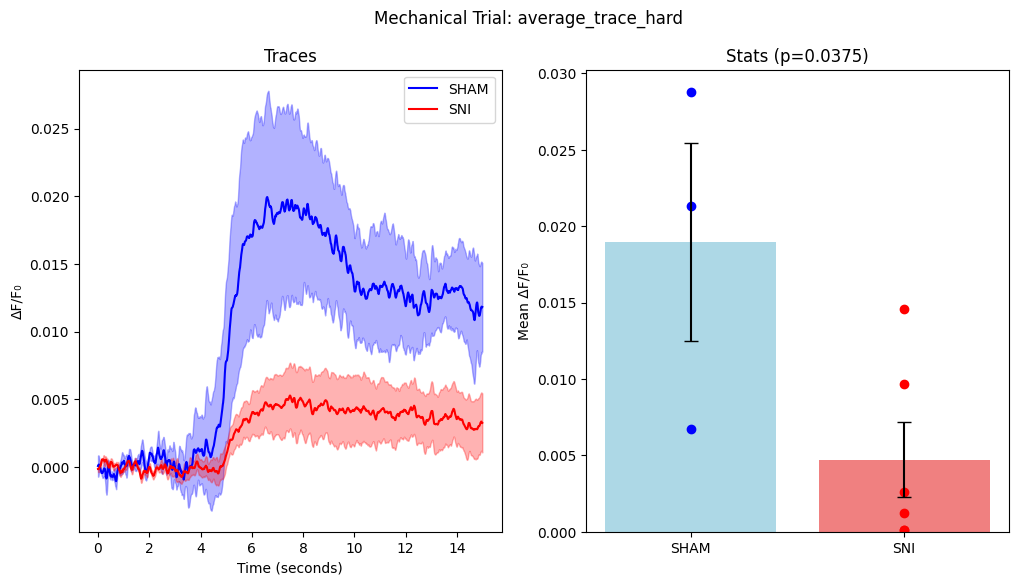

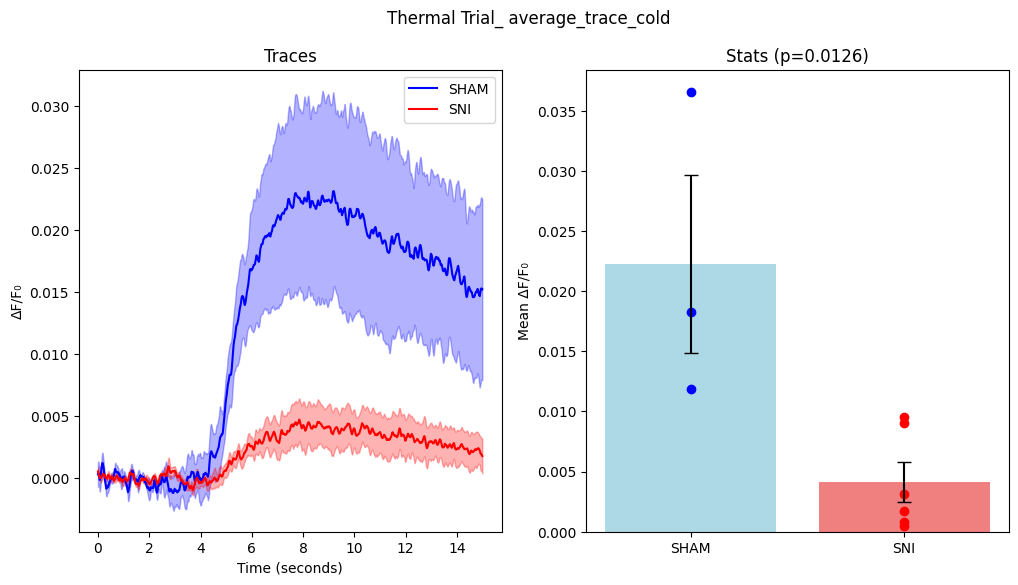

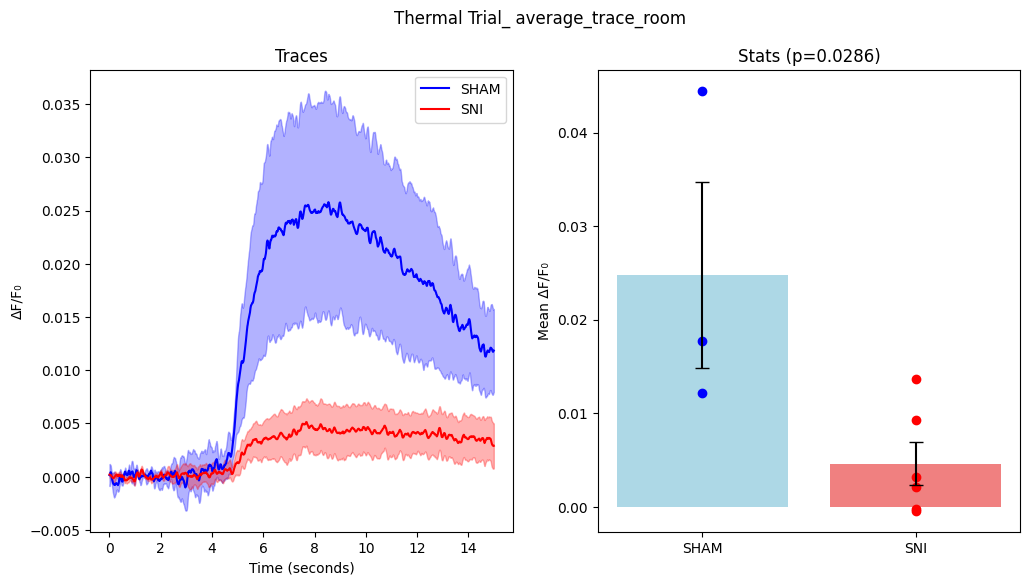

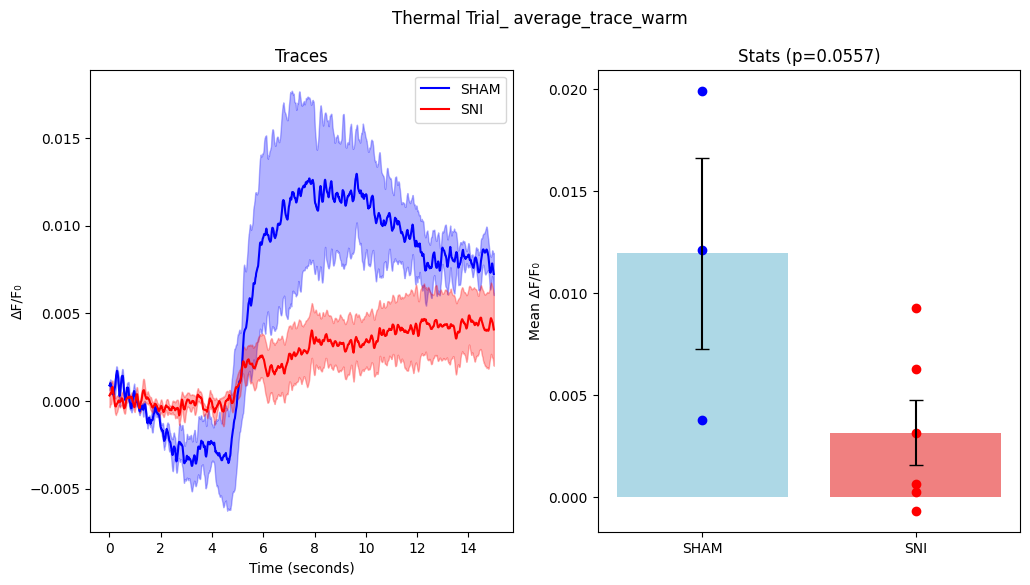

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
from scipy.ndimage import uniform_filter1d

# Paths to the data directories
sni_path = r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\SNI/'
sham_path = r'H:\Magdalena\photometry\fp_recordings\ACh_sensory\sham/'


# Function to load the data
def load_data(path):
    return {animal: np.load(os.path.join(path, animal), allow_pickle=True) 
            for animal in os.listdir(path) if animal.endswith('.npy')}

# Load SHAM and SNI data
sham_data = load_data(sham_path)
sni_data = load_data(sni_path)

# Define trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to extract trials for each animal
def extract_trials_per_animal(animal_data, trial_types):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                animal_trials[trial] = data.item()[trial]
        trials[animal] = animal_trials
    return trials

# Function to apply smoothing to the data
def smooth_trace(trace, window_size=1):
    return uniform_filter1d(trace, size=window_size)

# Extracting and smoothing trials for each condition
def extract_and_smooth_trials(animal_data, trial_types, window_size=5):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                smoothed_trace = smooth_trace(data.item()[trial], window_size)
                animal_trials[trial] = smoothed_trace
        trials[animal] = animal_trials
    return trials

sham_mechanical_data = extract_and_smooth_trials(sham_data, mechanical_trials)
sni_mechanical_data = extract_and_smooth_trials(sni_data, mechanical_trials)

sham_thermal_data = extract_and_smooth_trials(sham_data, thermal_trials)
sni_thermal_data = extract_and_smooth_trials(sni_data, thermal_trials)

# Function to calculate average and SEM across all animals for each trial type
def calculate_avg_sem_across_animals(data_per_animal, trial_types):
    avg_sem = {}
    for trial in trial_types:
        trial_data = np.array([animal_data[trial] for animal_data in data_per_animal.values() if trial in animal_data])
        avg, sem_val = np.mean(trial_data, axis=0), sem(trial_data, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Calculate average and SEM for each condition
sham_mechanical_avg_sem = calculate_avg_sem_across_animals(sham_mechanical_data, mechanical_trials)
sni_mechanical_avg_sem = calculate_avg_sem_across_animals(sni_mechanical_data, mechanical_trials)

sham_thermal_avg_sem = calculate_avg_sem_across_animals(sham_thermal_data, thermal_trials)
sni_thermal_avg_sem = calculate_avg_sem_across_animals(sni_thermal_data, thermal_trials)

# Function to calculate mean in the specified index range and perform statistical tests
def compare_conditions(sham_data, sni_data, trial_types, sampling_rate, start_time, end_time):
    stats_results = {}
    start_index = int(start_time * sampling_rate)
    end_index = int(end_time * sampling_rate)
    
    for trial in trial_types:
        sham_means = [np.mean(data[trial][start_index:end_index]) for data in sham_data.values() if trial in data]
        sni_means = [np.mean(data[trial][start_index:end_index]) for data in sni_data.values() if trial in data]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(sham_means, sni_means)
        stats_results[trial] = (sham_means, sni_means, t_stat, p_value)
    
    return stats_results

# Compare SHAM and SNI for mechanical and thermal trials
mechanical_stats = compare_conditions(sham_mechanical_data, sni_mechanical_data, mechanical_trials, 130, 5.5, 6.5)
thermal_stats = compare_conditions(sham_thermal_data, sni_thermal_data, thermal_trials, 130, 5.5, 6.5)

# Updated color codes
color_sham = 'blue'
color_sni = 'red'
light_color_sham = '#add8e6'  # Light blue
light_color_sni = '#f08080'   # Light red

# Plotting function
def plot_comparison(sham_data, sni_data, stats, trial_type, title, sampling_rate):
    time_axis = np.arange(len(sham_data[trial_type][0])) / sampling_rate
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot SHAM and SNI traces
    sham_avg, sham_sem = sham_data[trial_type]
    sni_avg, sni_sem = sni_data[trial_type]
    
    axs[0].plot(time_axis, sham_avg, label='SHAM', color=color_sham)
    axs[0].fill_between(time_axis, sham_avg - sham_sem, sham_avg + sham_sem, color=color_sham, alpha=0.3)
    
    axs[0].plot(time_axis, sni_avg, label='SNI', color=color_sni)
    axs[0].fill_between(time_axis, sni_avg - sni_sem, sni_avg + sni_sem, color=color_sni, alpha=0.3)
    
    axs[0].set_title('Traces')
    axs[0].set_xlabel('Time (seconds)')
    axs[0].set_ylabel('ΔF/F₀')
    axs[0].legend()

    # Plot stats (mean +/- SEM and individual points)
    sham_means, sni_means, t_stat, p_value = stats[trial_type]
    
    # Plot bars first
    axs[1].bar(['SHAM', 'SNI'], [np.mean(sham_means), np.mean(sni_means)], 
               yerr=[sem(sham_means), sem(sni_means)], capsize=5, color=[light_color_sham, light_color_sni])
    
    # Plot individual data points on top of bars
    axs[1].scatter(['SHAM']*len(sham_means), sham_means, color=color_sham)
    axs[1].scatter(['SNI']*len(sni_means), sni_means, color=color_sni)
    
    axs[1].set_title(f'Stats (p={p_value:.4f})')
    axs[1].set_ylabel('Mean ΔF/F₀')
    
    plt.suptitle(title)
    # saving the figure
    
    save_path = os.path.join(os.path.dirname(extract_folder_path), title + '.pdf')
    plt.savefig(save_path, format='pdf', dpi=300)

    plt.show()

# Plotting mechanical trials
for trial in mechanical_trials:
    plot_comparison(sham_mechanical_avg_sem, sni_mechanical_avg_sem, mechanical_stats, trial, f"Mechanical Trial_ {trial}", sampling_rate)

# Plotting thermal trials
for trial in thermal_trials:
    plot_comparison(sham_thermal_avg_sem, sni_thermal_avg_sem, thermal_stats, trial, f"Thermal Trial_ {trial}", sampling_rate)


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
from scipy.ndimage import uniform_filter1d

# Paths to the data directories
sham_path = 'C:/files/data/sensory_stim/temp/sham/'
sni_path = 'C:/files/data/sensory_stim/temp/sni/'

# Function to load the data
def load_data(path):
    return {animal: np.load(os.path.join(path, animal), allow_pickle=True) 
            for animal in os.listdir(path) if animal.endswith('.npy')}

# Load SHAM and SNI data
sham_data = load_data(sham_path)
sni_data = load_data(sni_path)

# Define trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to apply smoothing to the data
def smooth_trace(trace, window_size=1):
    return uniform_filter1d(trace, size=window_size)

# Debug function to inspect data structure
def inspect_data(data):
    for animal, animal_data in data.items():
        print(f"Animal: {animal}")
        if isinstance(animal_data.item(), dict):
            for key, value in animal_data.item().items():
                print(f"  Key: {key}, Shape: {np.array(value).shape}")
        else:
            print(f"  Data type: {type(animal_data.item())}")
        print("----")

# Inspect the data structure
print("SHAM Data Structure:")
inspect_data(sham_data)
print("\nSNI Data Structure:")
inspect_data(sni_data)

# Function to extract and smooth trials, pooling across animals
def extract_and_smooth_trials(animal_data, trial_types, window_size=5):
    pooled_trials = {trial: [] for trial in trial_types}
    for animal, data in animal_data.items():
        if isinstance(data.item(), dict):
            for trial in trial_types:
                if trial in data.item():
                    trial_data = np.array(data.item()[trial])
                    if trial_data.ndim == 1:  # Single trial
                        smoothed_trace = smooth_trace(trial_data, window_size)
                        pooled_trials[trial].append(smoothed_trace)
                    elif trial_data.ndim == 2:  # Multiple trials
                        for single_trial in trial_data:
                            smoothed_trace = smooth_trace(single_trial, window_size)
                            pooled_trials[trial].append(smoothed_trace)
    return pooled_trials

# Extract and smooth trials for each condition
sham_mechanical_data = extract_and_smooth_trials(sham_data, mechanical_trials)
sni_mechanical_data = extract_and_smooth_trials(sni_data, mechanical_trials)
sham_thermal_data = extract_and_smooth_trials(sham_data, thermal_trials)
sni_thermal_data = extract_and_smooth_trials(sni_data, thermal_trials)

# Function to calculate average and SEM across all trials
def calculate_avg_sem_across_trials(pooled_trials):
    avg_sem = {}
    for trial, trials_data in pooled_trials.items():
        trials_array = np.array(trials_data)
        avg, sem_val = np.mean(trials_array, axis=0), sem(trials_array, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Calculate average and SEM for each condition
sham_mechanical_avg_sem = calculate_avg_sem_across_trials(sham_mechanical_data)
sni_mechanical_avg_sem = calculate_avg_sem_across_trials(sni_mechanical_data)
sham_thermal_avg_sem = calculate_avg_sem_across_trials(sham_thermal_data)
sni_thermal_avg_sem = calculate_avg_sem_across_trials(sni_thermal_data)

# Function to calculate mean in the specified index range and perform statistical tests
def compare_conditions(sham_data, sni_data, trial_types, sampling_rate, start_time, end_time):
    stats_results = {}
    start_index = int(start_time * sampling_rate)
    end_index = int(end_time * sampling_rate)
    
    for trial in trial_types:
        sham_means = [np.mean(trace[start_index:end_index]) for trace in sham_data[trial]]
        sni_means = [np.mean(trace[start_index:end_index]) for trace in sni_data[trial]]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(sham_means, sni_means)
        stats_results[trial] = (sham_means, sni_means, t_stat, p_value)
    
    return stats_results

# Compare SHAM and SNI for mechanical and thermal trials
mechanical_stats = compare_conditions(sham_mechanical_data, sni_mechanical_data, mechanical_trials, 130, 5.5, 6.5)
thermal_stats = compare_conditions(sham_thermal_data, sni_thermal_data, thermal_trials, 130, 5.5, 6.5)

# Color codes
color_sham = 'blue'
color_sni = 'red'
light_color_sham = '#add8e6'  # Light blue
light_color_sni = '#f08080'   # Light red

# Plotting function
def plot_comparison(sham_data, sni_data, stats, trial_type, title, sampling_rate):
    time_axis = np.arange(len(sham_data[trial_type][0])) / sampling_rate
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot SHAM and SNI traces
    sham_avg, sham_sem = sham_data[trial_type]
    sni_avg, sni_sem = sni_data[trial_type]
    
    axs[0].plot(time_axis, sham_avg, label='SHAM', color=color_sham)
    axs[0].fill_between(time_axis, sham_avg - sham_sem, sham_avg + sham_sem, color=color_sham, alpha=0.3)
    
    axs[0].plot(time_axis, sni_avg, label='SNI', color=color_sni)
    axs[0].fill_between(time_axis, sni_avg - sni_sem, sni_avg + sni_sem, color=color_sni, alpha=0.3)
    
    axs[0].set_title('Traces')
    axs[0].set_xlabel('Time (seconds)')
    axs[0].set_ylabel('ΔF/F₀')
    axs[0].legend()

    # Plot stats (mean +/- SEM and individual points)
    sham_means, sni_means, t_stat, p_value = stats[trial_type]
    
    # Plot bars first
    axs[1].bar(['SHAM', 'SNI'], [np.mean(sham_means), np.mean(sni_means)], 
               yerr=[sem(sham_means), sem(sni_means)], capsize=5, color=[light_color_sham, light_color_sni])
    
    # Plot individual data points on top of bars
    axs[1].scatter(['SHAM']*len(sham_means), sham_means, color=color_sham, alpha=0.5, s=20)
    axs[1].scatter(['SNI']*len(sni_means), sni_means, color=color_sni, alpha=0.5, s=20)
    
    axs[1].set_title(f'Stats (p={p_value:.4f})\nSHAM: {len(sham_means)} trials, SNI: {len(sni_means)} trials')
    axs[1].set_ylabel('Mean ΔF/F₀')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plotting mechanical trials
for trial in mechanical_trials:
    plot_comparison(sham_mechanical_avg_sem, sni_mechanical_avg_sem, mechanical_stats, trial, f"Mechanical Trial: {trial}", 130)

# Plotting thermal trials
for trial in thermal_trials:
    plot_comparison(sham_thermal_avg_sem, sni_thermal_avg_sem, thermal_stats, trial, f"Thermal Trial: {trial}", 130)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/files/data/sensory_stim/temp/sham/'